In [1]:
import pickle
from pandas import DataFrame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import Layout
import pathlib

plt.rcParams["figure.figsize"] = (14, 7) # (w, h)
pair_address = "0x85Cb0baB616Fe88a89A35080516a8928F38B518b"
cache_df_path = f"data/{pair_address}_by_block_df.pkl"
sync_swap_df = f"test/local_node/state/{pair_address}_df.pkl"

state_df = pickle.load(open(sync_swap_df, "rb"))
state_df.head()

def index_by_block_and_cache(state_df: DataFrame) -> DataFrame:
    block_df = (state_df[['block', 'amount0In', 'amount1In', 'amount0Out', 'amount1Out', 'reserve0', 'reserve1']]).groupby(
        state_df.block, as_index=False).agg({
            'block': 'first', 'amount0In': sum, 'amount1In': sum, 'amount0Out': sum, 'amount1Out': sum, 'reserve0': 'first', 'reserve1': 'first'
        }).copy(deep=True)
    block_df.block = block_df.block.astype(int)

    block_df = block_df.set_index('block').reindex(np.arange(block_df.block.min(), block_df.block.max() + 1)).reset_index()
    block_df.reserve0 = block_df.reserve0.fillna(method='bfill')
    block_df.reserve1 = block_df.reserve1.fillna(method='bfill')
    block_df = block_df.fillna(value=0)
    block_df.to_pickle(cache_df_path)
    return block_df

# block_df is 172M due to intoducing a row for each block, build it and cache it to run cell faster on future runs.
block_df = pickle.load(open(cache_df_path, "rb")) \
    if pathlib.Path(cache_df_path).exists() \
    else index_by_block_and_cache(pickle.load(open(sync_swap_df, "rb")))

rates_df = DataFrame({
    "block": block_df["block"],
    "y_per_x": block_df["reserve1"] / block_df["reserve0"],
    "x_per_y": block_df["reserve0"] / block_df["reserve1"]
})


In [2]:
block_df.head()

,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1
0,11876000,172168679926519706,1000000000000000000,17216867992651970607,29238993545300586,25851205000000000000,500000000000000000
1,11876001,0,0,0,0,13596682010212464215,2270761006454699413
2,11876002,0,0,0,0,13596682010212464215,2270761006454699413
3,11876003,0,0,0,0,13596682010212464215,2270761006454699413
4,11876004,0,0,0,0,13596682010212464215,2270761006454699413


# Reserve based price vs Volume weighted average price

Price is usually measured by the state of the reserves at the end of a block. Another way to meausre price is considering the rate each swap executes at. This can be chaotic with multiple swaps in either direction in a block, but we might group these rates within a block using a volume weighted average. Lets compare how these values would differ from a reserved based price

In [3]:
prices_df = DataFrame(block_df["block"])

# Add reserve based price
prices_df["reserve0/reserve1"] = block_df["reserve0"] / block_df["reserve1"]

# Add Volume based price, use last price if no volume exists
prices_df["volume0/volume1"] = (block_df["amount0In"] + block_df["amount0Out"]).divide(
    (block_df["amount1In"] + block_df["amount1Out"]).replace({ 0 : np.nan })).fillna(method='ffill')

# seperated volume values
prices_df["volume_sell_0_0per1"] = (block_df["amount0In"]).divide(
    (block_df["amount1Out"]).replace({ 0 : np.nan })).fillna(method='ffill')
prices_df["volume_sell_1_0per1"] = (block_df["amount0Out"]).divide(
    (block_df["amount1In"]).replace({ 0 : np.nan })).fillna(method='ffill')
prices_df["volume_sell_0_1per0"] = 1 / prices_df["volume_sell_0_0per1"]
prices_df["volume_sell_1_1per0"] = 1 / prices_df["volume_sell_1_0per1"]

prices_df = prices_df.set_index('block')

In [4]:
prices_df.head()

,reserve0/reserve1,volume0/volume1,volume_sell_0_0per1,volume_sell_1_0per1,volume_sell_0_1per0,volume_sell_1_1per0
block,,,,,,
11876000,51.70241,16.895043,5.888324,17.216868,0.169828,0.058083
11876001,5.98772,16.895043,5.888324,17.216868,0.169828,0.058083
11876002,5.98772,16.895043,5.888324,17.216868,0.169828,0.058083
11876003,5.98772,16.895043,5.888324,17.216868,0.169828,0.058083
11876004,5.98772,16.895043,5.888324,17.216868,0.169828,0.058083


<AxesSubplot: xlabel='block'>

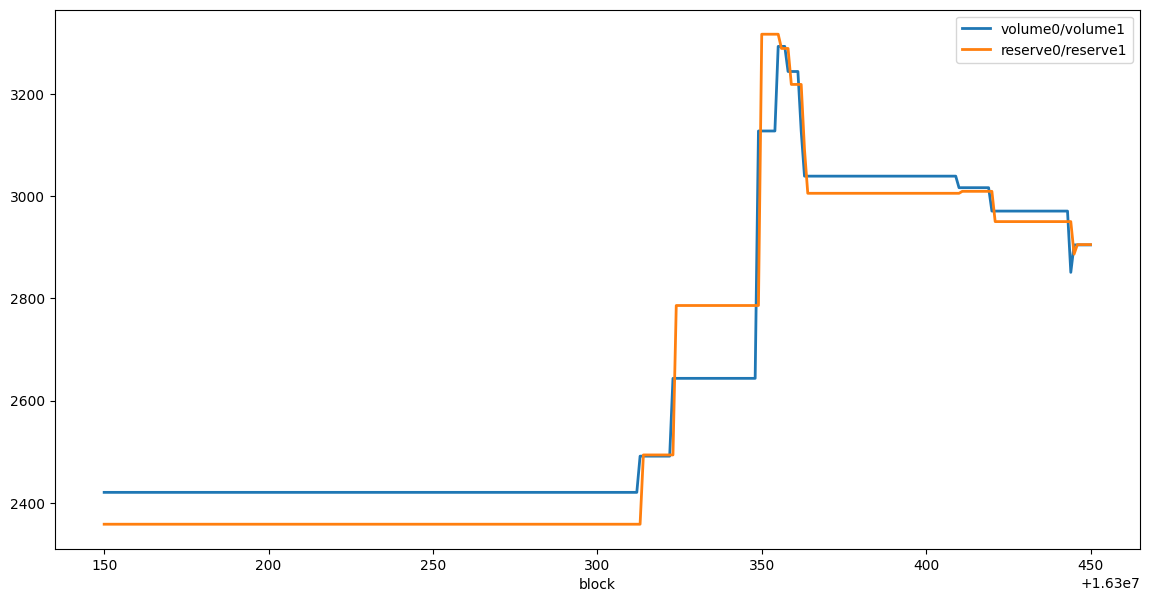

In [5]:
prices_df[["volume0/volume1", "reserve0/reserve1"]] \
    [(16300150 <= prices_df.index) & (prices_df.index <= 16300450)].plot(linewidth=2)

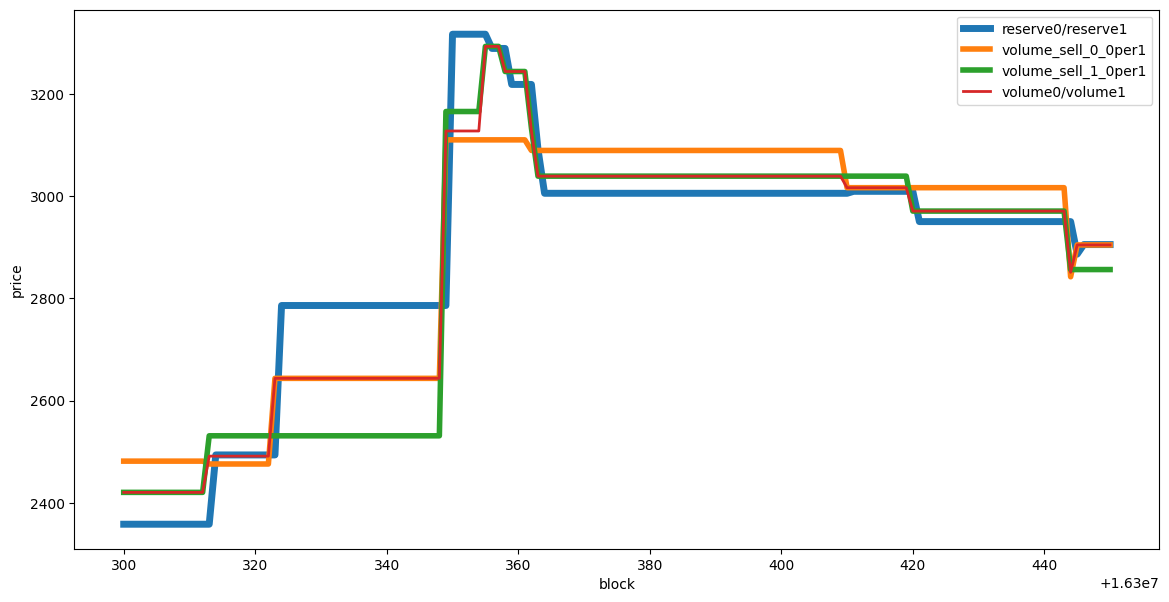

In [6]:
price_compare = prices_df[["reserve0/reserve1", "volume_sell_0_0per1", "volume_sell_1_0per1", "volume0/volume1"]] \
    [(16300300 <= prices_df.index) & (prices_df.index <= 16300450)]
plt.plot(price_compare[["reserve0/reserve1"]], label = "reserve0/reserve1", linewidth=5)
plt.plot(price_compare[["volume_sell_0_0per1", "volume_sell_1_0per1"]], label = ["volume_sell_0_0per1", "volume_sell_1_0per1"], linewidth=4)
plt.plot(price_compare[["volume0/volume1"]], label = "volume0/volume1", linewidth=2)
plt.xlabel("block")
plt.ylabel('price')
plt.legend()
plt.show()

# 30 Minute Oracle Comparison on ETH-POOL Uniswap V2 Pair

Here we look at the ETH-POOL pair, a low liquidity trading pair, to understand how variout price calculations for our oracle would work. 

## Construct Oracles

Our dataframe starts with swaps and reserves prior to swaps. Using this data we crunch some numbers to build build various oraclse. Since we do not have time which our scanner does not grab, we use blocks thus BWAP rather than TWAP. If every block was 12 seconds exactly, this would be the same, but since that is not the case, there are some minor erorrs. 

In [7]:
class OracleBuilder:
    tick_log = math.log(1.0001)

    def __init__(self, block_df: DataFrame):
        self.block_df = block_df
        self.df = DataFrame(block_df.loc[:, ("block")])
    
    @staticmethod
    def new_builder(block_df: DataFrame) -> 'OracleBuilder':
        return OracleBuilder(block_df)
    
    def add_reserve_price(self) -> 'OracleBuilder':
        self.df["current_price"] = (self.block_df['reserve0'] / self.block_df['reserve1'])
        return self
    
    def add_shifted_reserve_price(self, minutes) -> 'OracleBuilder':
        half_blocks = int(self.minutes_to_blocks(minutes) / 2)
        current_price = self.df["current_price"] if "current_price" in self.df.columns else self.block_df['reserve0'] / self.block_df['reserve1']
        self.df[f"shifted_price_{half_blocks}"] = current_price.shift(periods=half_blocks)
        return self
    
    def add_twap(self, minutes) -> 'OracleBuilder':
        blocks = self.minutes_to_blocks(minutes)
        cumsum_x_per_y = self.block_df.loc[:, ('reserve0')].divide(self.block_df['reserve1']).cumsum()
        cumsum_y_per_x = self.block_df.loc[:, ('reserve1')].divide(self.block_df['reserve0']).cumsum()
        self.df[f"twap_{minutes}_x_per_y"] = (cumsum_x_per_y - cumsum_x_per_y.shift(blocks)).divide(blocks)
        return self
    
    def add_geom_twap(self, minutes) -> 'OracleBuilder':
        blocks = self.minutes_to_blocks(minutes)
        tick_sum = (np.log((self.block_df['reserve0'] / self.block_df['reserve1']).astype(float)) / self.tick_log).cumsum()
        self.df[F"geom_twap_{minutes}_x_per_y"] = np.power(
            1.0001, (tick_sum - tick_sum.shift(blocks)) / blocks
        )
        return self
    
    def add_vwap(self, minutes) -> 'OracleBuilder':
        blocks = self.minutes_to_blocks(minutes)
        cumsum_x_in = self.block_df["amount0In"].cumsum()
        cumsum_y_out = self.block_df["amount1Out"].cumsum()
        cumsum_y_in = self.block_df["amount1In"].cumsum()
        cumsum_x_out = self.block_df["amount0Out"].cumsum()
        self.df[f"vwap_{minutes}_x_per_y"] = (
            cumsum_x_in + cumsum_x_out - (cumsum_x_in + cumsum_x_out).shift(blocks)).divide(
            (cumsum_y_in + cumsum_y_out - (cumsum_y_in + cumsum_y_out).shift(blocks)).replace({ 0 : np.nan }))
        return self
    
    def add_proposed(self, minutes) -> 'OracleBuilder':
        blocks = self.minutes_to_blocks(minutes)
        geom_0In_1Out = (np.log((self.block_df["amount0In"] / self.block_df["amount1Out"].replace({0: np.nan})).fillna(method='ffill')) / self.tick_log).cumsum()
        geom_1In_0Out = (np.log((self.block_df["amount0Out"] / self.block_df["amount1In"].replace({0: np.nan})).fillna(method='ffill')) / self.tick_log).cumsum()
        self.df[f'proposed_0In_1Out_oracle_{minutes}'] = np.power(1.0001, (geom_0In_1Out - geom_0In_1Out.shift(blocks)) / blocks)
        self.df[f'proposed_1In_0Out_oracle_{minutes}'] = np.power(1.0001, (geom_1In_0Out - geom_1In_0Out.shift(blocks)) / blocks)
        return self

    @staticmethod
    def minutes_to_blocks(minutes):
        return minutes * 5 # minutes * 60 second / 12 second per block

    def build(self) -> DataFrame:
        return self.df


oracle_df = OracleBuilder.new_builder(block_df) \
    .add_reserve_price() \
    .add_shifted_reserve_price(30) \
    .add_twap(30) \
    .add_geom_twap(30) \
    .add_vwap(30) \
    .add_proposed(30) \
    .build()

<AxesSubplot: title={'center': 'POOL per ETH Reserves Based Price Uniswap V2 Pair'}, xlabel='block', ylabel='POOL/ETH'>

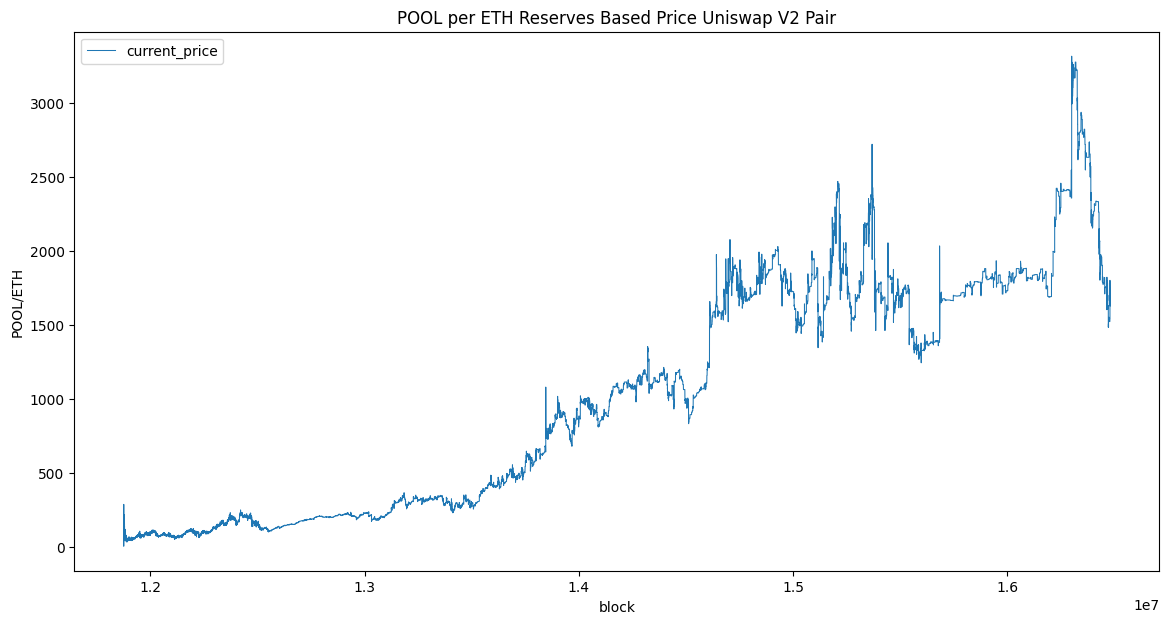

In [8]:
oracle_df[["block", "current_price"]].plot(linewidth=.75, x="block", ylabel="POOL/ETH", title="POOL per ETH Reserves Based Price Uniswap V2 Pair")

# Proposed oracle calculationsin comparison to twap and geometric twap

Our proposed oracle calculation tracks what assets are tracking rather than what the state of the reserves in the pair are. Below we show each oracle calculation along with the price based on the reserves shifted forward to overlay with what the oracles which lag. The twaps break from the reserves briefly until the opposite direction trades occur at which point the twaps start decreaeasing towards the new reserve prices. The rate at which the swaps execute at are higher than the values the twaps track. The proposed oracle more closely follows the actual price, not the reserve based price. 

<AxesSubplot: xlabel='block'>

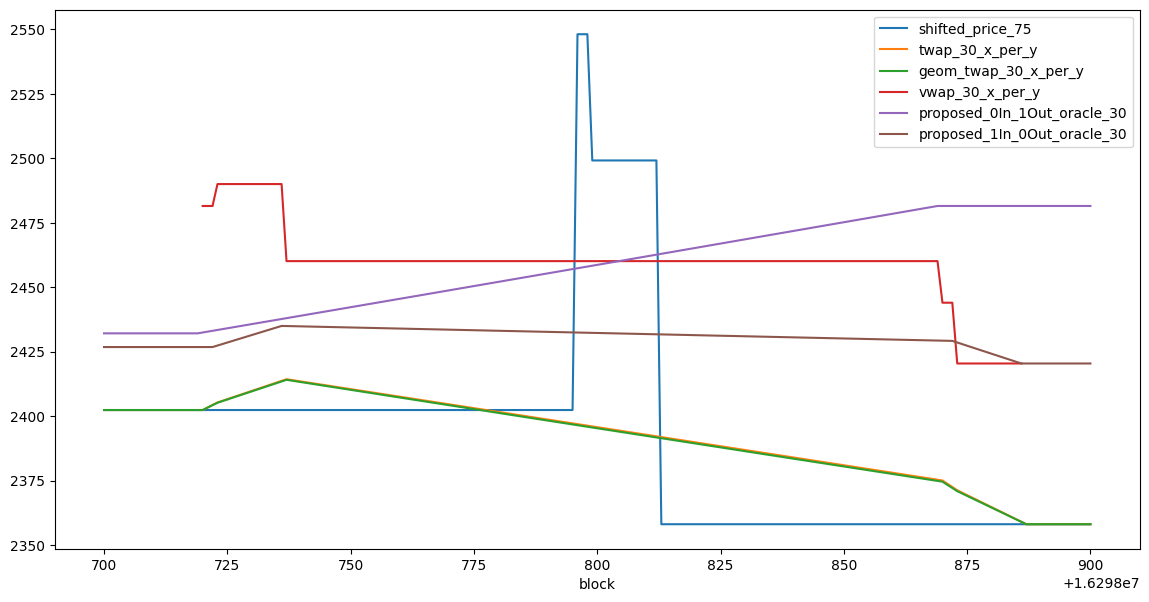

In [9]:
oracle_df.drop('current_price', axis=1)[(16298700 <= oracle_df.block) & (
    # oracle_df.index <= 16300600
    oracle_df.block <= 16298900

)].plot(x="block")


<AxesSubplot: xlabel='block'>

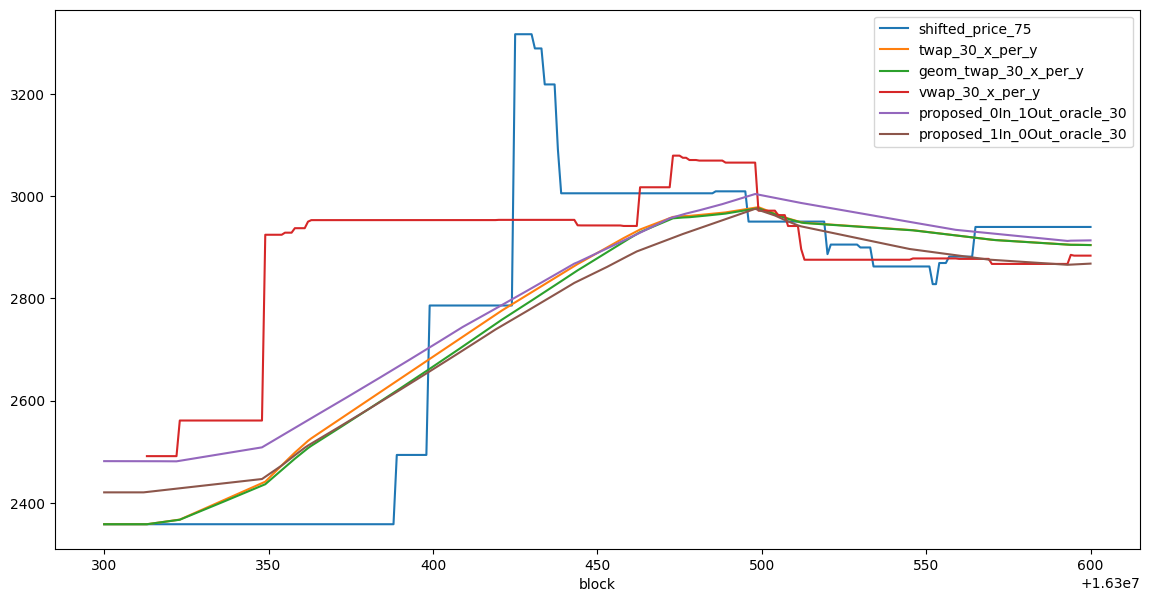

In [10]:
oracle_df.drop('current_price', axis=1)[(16300300 <= oracle_df.block) & (
    oracle_df.block <= 16300600
)].plot(x="block")

# Largest price moves in one block

Below we look at the largest moves in one block. Our first list has 17/20 in the first 24 hours of the pair getting created. 

In [11]:
big_moves_df = DataFrame({
    "block": block_df["block"],
    "amount0In_per_reserve0": block_df["amount0In"] / block_df["reserve0"],
    "amount1In_per_reserve1": block_df["amount1In"] / block_df["reserve1"],
    "amount0Net_per_reserve0": (block_df["amount0In"] - block_df["amount0Out"]) / block_df["reserve0"],
    "amount1Net_per_reserve1": (block_df["amount1In"] - block_df["amount1Out"]) / block_df["reserve1"],
})

big_moves_df["max_amountIn_per_reserve"] = big_moves_df[[
    "amount0In_per_reserve0", "amount1In_per_reserve1"
]].max(axis=1)
big_moves_df["max_amountNet_per_reserve"] = big_moves_df[[
    "amount0Net_per_reserve0", "amount1Net_per_reserve1"
]].max(axis=1)


big_moves_df.sort_values("max_amountNet_per_reserve", ascending=False).reset_index(drop=True)
big_moves_df.head()

,block,amount0In_per_reserve0,amount1In_per_reserve1,amount0Net_per_reserve0,amount1Net_per_reserve1,max_amountIn_per_reserve,max_amountNet_per_reserve
0,11876000,0.00666,2.0,-0.659339,1.941522,2.0,1.941522
1,11876001,0.0,0.0,0.0,0.0,0.0,0.000000
2,11876002,0.0,0.0,0.0,0.0,0.0,0.000000
3,11876003,0.0,0.0,0.0,0.0,0.0,0.000000
4,11876004,0.0,0.0,0.0,0.0,0.0,0.000000


Lets drop the first 24 hours to look at the largest moves after the market has found some equilibrium after initialization

In [12]:
sorted_net_moves_df = big_moves_df.iloc[7200:].sort_values("max_amountNet_per_reserve", ascending=False).reset_index(drop=True)
sorted_net_moves_df.head(10)

,block,amount0In_per_reserve0,amount1In_per_reserve1,amount0Net_per_reserve0,amount1Net_per_reserve1,max_amountIn_per_reserve,max_amountNet_per_reserve
0,13845789,0.297619,0.0,0.297619,-0.228827,0.297619,0.297619
1,12215728,0.0,0.180044,-0.152186,0.180044,0.180044,0.180044
2,11950780,0.164481,0.0,0.164481,-0.140884,0.164481,0.164481
3,11892712,0.143585,0.0,0.143585,-0.125227,0.143585,0.143585
4,11913006,0.141817,0.0,0.141817,-0.123876,0.141817,0.141817
5,11900698,0.134465,0.0,0.134465,-0.118214,0.134465,0.134465
6,15442876,0.134218,0.0,0.134218,-0.118022,0.134218,0.134218
7,13032464,0.001424,0.130006,-0.113319,0.128197,0.130006,0.128197
8,15684118,0.010373,0.140461,-0.112464,0.127171,0.140461,0.127171
9,11892713,0.0,0.122017,-0.108457,0.122017,0.122017,0.122017


## Examining some of the largest moves 

Below is a chart of the largest moves. 

<AxesSubplot: >

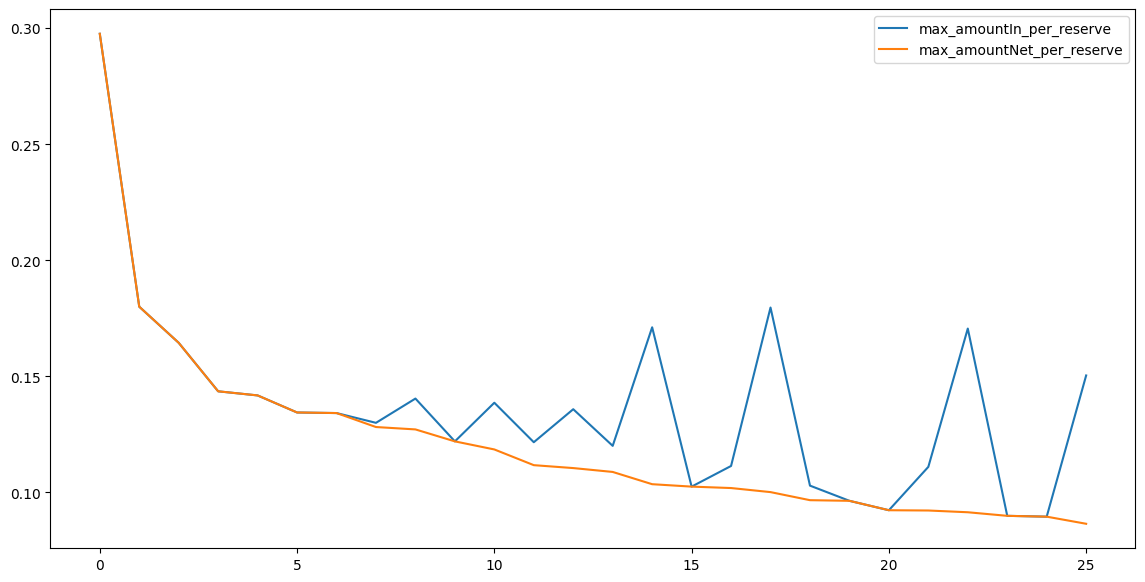

In [13]:
sorted_net_moves_df[(sorted_net_moves_df.index  <= 25)][["max_amountIn_per_reserve", "max_amountNet_per_reserve"]].plot()

#### Looking at how the market and oracles behave after the largest shift in price

In [14]:
b = sorted_net_moves_df["block"][0]
block_df[(b -5 <= block_df["block"]) & (block_df["block"] <= b + 20)]

,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1
1969784,13845784,0,0,0,0,153212210186396951314993,238716385955530719051
1969785,13845785,0,0,0,0,153212210186396951314993,238716385955530719051
1969786,13845786,0,0,0,0,153212210186396951314993,238716385955530719051
1969787,13845787,0,0,0,0,153212210186396951314993,238716385955530719051
1969788,13845788,0,0,0,0,153212210186396951314993,238716385955530719051
1969789,13845789,45598914832797630699516,0,0,54624835640149345578,153212210186396951314993,238716385955530719051
1969790,13845790,4930032061697182061256,12071084298563895296,12227918575556074800253,5005352062942556724,198811125019194582014509,184091550315381373473
1969791,13845791,0,0,0,0,191513238505335689275512,191157282551002712045
1969792,13845792,0,6636305260866285568,6406902276717032296170,0,191513238505335689275512,191157282551002712045
1969793,13845793,5379873916932590788066,15270927886500831959,13229504248002106402496,6420108745716013110,185106336228618656979342,197793587811868997613


<AxesSubplot: xlabel='block'>

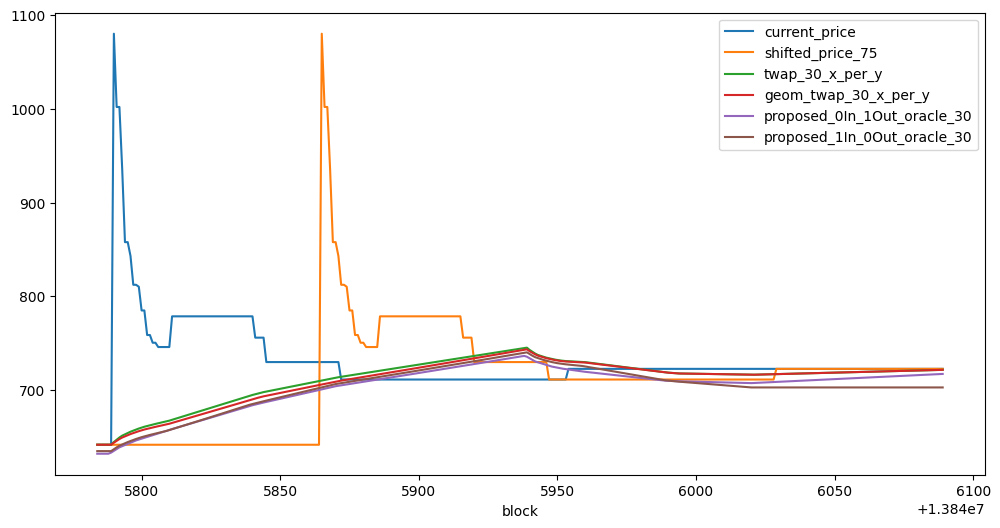

In [15]:
oracle_df[(b - 5 <= oracle_df.block)&(oracle_df.block <= b + 300)] \
    .drop(["vwap_30_x_per_y"], axis=1) \
    .plot(x="block", figsize=(12,6))

#### Interesting series of trades to come back to and look at

price fluctuates betwee 0.01 ETH / POOL to 0.026 ETH/Poool 

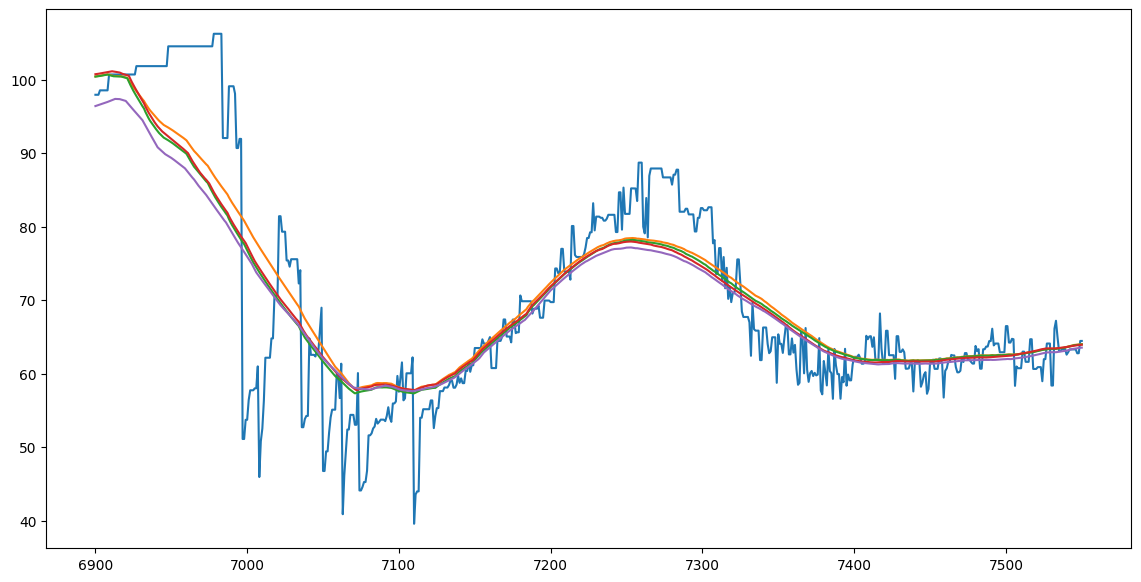

In [16]:
r = (11882900 <= oracle_df.block) & (oracle_df.block <=11883550)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot((oracle_df.drop(
    [
        'block',
        'current_price',
        # "shifted_price", 
        "vwap_30_x_per_y"], axis=1))[r])
b = 2900
